In [1]:
import PyKDL
import kdl_parser_py.urdf
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tf

import numpy as np
np.set_printoptions(suppress=True)


In [2]:
act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from policy import ACTPolicy
from brl_constants import TASK_CONFIGS

ckpt_path = "/mnt/data1/act/act_demo_scara_whiteboard_pick_one/rgb/"
config_path = ckpt_path + "config.pkl"
# step = 500000
# policy_model_path = ckpt_path + "policy_step_%i_seed_0.ckpt"%step
policy_model_path = ckpt_path + "policy_step_50000_seed_0.ckpt"

stats_path = ckpt_path + "dataset_stats.pkl"

with open(config_path, "rb") as f:
    policy_config = pickle.load(f)['policy_config']
    print(policy_config)

policy = ACTPolicy(policy_config)
# loading_status = policy.deserialize(torch.load(policy_model_path))

with open(stats_path, "rb") as f:
    stats = pickle.load(f)

pre_process_qpos = (
    lambda s_qpos: torch.from_numpy((s_qpos - stats["qpos_mean"]) / stats["qpos_std"])
    .float()
    .cuda()
    .unsqueeze(0)
)
post_process_action = lambda a: a * stats["action_std"] + stats["action_mean"]
BASE_DELAY = 13

print("loading ACT policy success")

ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /home/zfei/software/robomimic/robomimic/scripts/setup_macros.py
)
{'lr': 1e-05, 'num_queries': 100, 'kl_weight': 10, 'hidden_dim': 512, 'dim_feedforward': 3200, 'lr_backbone': 1e-05, 'backbone': 'resnet18', 'enc_layers': 4, 'dec_layers': 7, 'nheads': 8, 'camera_names': ['wrist'], 'vq': False, 'vq_class': None, 'vq_dim': None, 'action_dim': 5, 'state_dim': 4, 'no_encoder': False}
ACT Args:  Namespace(lr=1e-05, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, backbone='resnet18', dilation=False, position_embedding='sine', camera_names=['wrist'], enc_layers=4, dec_layers=7, dim_feedforward=3200, hidden_dim=512, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, eval=False, onscreen_render=False, ckpt_dir='/mnt/data1/act/act_demo_z1_push_red/ckpt', policy_class='ACT', task_name='act_demo_z1_push_re

/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future

Use end_pose_to_action:  True
Use VQ: False, None, None
number of parameters: 83.91M
KL Weight 10
loading ACT policy success


In [3]:
def pre_proccess_img(img):
    img_torch = torch.from_numpy(img).unsqueeze(0)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

In [4]:
h5data_file = "/mnt/data1/act/act_demo_scara_whiteboard_pick_one/data1/episode_15.hdf5"

with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        index = 0
        qpos_np = root["/observations/qpos"][index]
        img_np = root["/observations/images/wrist"][index]
        print("img_np: ",img_np.shape)

        action_obs_np = root["action"][()]
        qpos = pre_process_qpos(qpos_np)
        curr_img = pre_proccess_img(img_np)
        # print("qpos: ",qpos.shape)
        print("curr_img: ",curr_img.shape)
        all_actions = policy(qpos, curr_img)
        all_actions = all_actions.squeeze(0).cpu().numpy()

        print("all_actions: ", all_actions.shape)
        print("action_obs_np: ", action_obs_np.shape)

        # actual_action = post_process_action(raw_action)
        # print("actual action %i"%index, actual_action)



img_np:  (480, 640, 3)
curr_img:  torch.Size([1, 1, 3, 480, 640])
hs: torch.Size([1, 100, 512])
end_pose: torch.Size([1, 100, 6])
end_pose_mid: torch.Size([1, 100, 256])
a_hat: torch.Size([1, 100, 5])
all_actions:  (100, 5)
action_obs_np:  (154, 5)


: 

In [5]:
print(qpos_np)

[-0.0620264 -0.5401218 -1.0469148  1.6126493]


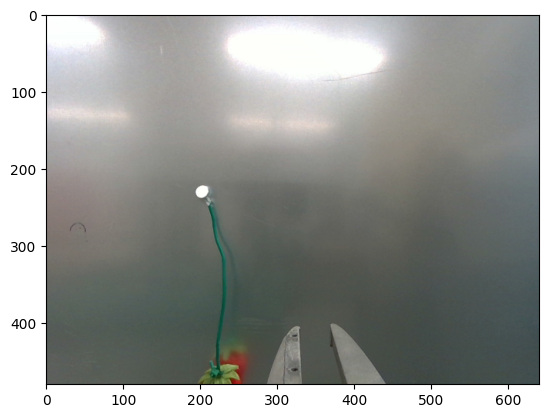

In [ ]:
plt.imshow(cv.cvtColor(img_np, cv.COLOR_BGR2RGB))

In [ ]:
joint_states_traj = []
actual_actions = []
for i, raw_action in enumerate(all_actions):
    actual_action = post_process_action(raw_action)
    actual_actions.append(actual_action)
actual_actions = np.asarray(actual_actions)
# print(actual_actions)

In [ ]:
actual_action[:4]

array([-0.07250058, -0.29814512, -1.0155243 ,  1.2973418 ], dtype=float32)

In [ ]:
actual_action[4]

0.00076243794

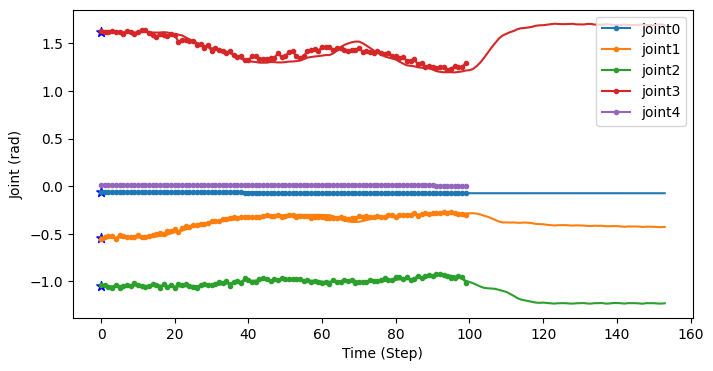

In [ ]:
# plot all joint states and label them
plt.figure(figsize=(8, 4))
plt.plot(actual_actions[:, 0], marker=".", label='joint0')
plt.plot(actual_actions[:, 1], marker=".", label='joint1')
plt.plot(actual_actions[:, 2], marker=".", label='joint2')
plt.plot(actual_actions[:, 3], marker=".", label='joint3')
plt.plot(actual_actions[:, 4], marker=".", label='joint4')

plt.xlabel("Time (Step)")
plt.ylabel("Joint (rad)")
plt.legend()


plt.scatter(0, qpos_np[0], marker="*", c="b", s=50, label='joint0')
plt.scatter(0, qpos_np[1], marker="*", c="b", s=50, label='joint1')
plt.scatter(0, qpos_np[2], marker="*", c="b", s=50, label='joint2')
plt.scatter(0, qpos_np[3], marker="*", c="b", s=50, label='joint3')
# plt.plot(np.arange(0, len(qpos_gts), 1), qpos_gts, c="r", label='joint5')
steps_plot = np.arange(0, len(action_obs_np), 1)
plt.plot(steps_plot, action_obs_np[:, 0],  c="C%i"%(0 ), label='joint0')
plt.plot(steps_plot, action_obs_np[:, 1],  c="C%i"%(1 ), label='joint1')
plt.plot(steps_plot, action_obs_np[:, 2],  c="C%i"%(2 ), label='joint2')
plt.plot(steps_plot, action_obs_np[:, 3],  c="C%i"%(3 ), label='joint3')

In [ ]:
# plt.figure(figsize=(8, 4))
# qpos_gts = []
# all_actual_actions = []
# with torch.inference_mode():
#     with h5py.File(h5data_file, "r") as root:
#         for index in range(100):
#             start_step = index 
#             qpos_np = root["/observations/qpos"][index]
#             qpos_gts.append(qpos_np.copy())
#             img_np = root["/observations/images/wrist"][index]
#             qpos = pre_process_qpos(qpos_np)
#             curr_img = pre_proccess_img(img_np)
#             # print("qpos: ",qpos.shape)
#             # print("curr_img: ",curr_img.shape)
#             all_actions = policy(qpos, curr_img)
#             all_actions = all_actions.squeeze(0).cpu().numpy()
#             joint_states_traj = []
#             actual_actions = []
#             steps = np.arange(0, len(all_actions), 1)
#             steps = steps + start_step
#             for i, raw_action in enumerate(all_actions):
#                 actual_action = post_process_action(raw_action)
#                 actual_actions.append(actual_action)
#             actual_actions = np.asarray(actual_actions)
#             all_actual_actions.append(actual_actions)
#             plt.plot(steps, actual_actions[:, 0], marker=".", c="C0", label='joint0')
#             plt.plot(steps, actual_actions[:, 1], marker=".", c="C1", label='joint1')
#             plt.plot(steps, actual_actions[:, 2], marker=".", c="C2", label='joint2')
#             plt.plot(steps, actual_actions[:, 3], marker=".", c="C3", label='joint3')
#             plt.plot(steps, actual_actions[:, 4], marker=".", c="C4", label='joint4')
# qpos_gts = np.asarray(qpos_gts)
# plt.xlabel("Time (Step)")
# plt.ylabel("Joint (rad)")
# plt.scatter(len(qpos_gts), qpos_np[0], marker="*", c="b", s=50, label='joint0')
# plt.scatter(len(qpos_gts), qpos_np[1], marker="*", c="b", s=50, label='joint1')
# plt.scatter(len(qpos_gts), qpos_np[2], marker="*", c="b", s=50, label='joint2')
# plt.scatter(len(qpos_gts), qpos_np[3], marker="*", c="b", s=50, label='joint3')
# plt.plot(np.arange(0, len(qpos_gts), 1), qpos_gts, c="r", label='joint5')


# plt.plot(action_obs_np[:, 0], c="g",label='joint0')
# plt.plot(action_obs_np[:, 1], c="g",label='joint1')
# plt.plot(action_obs_np[:, 2], c="g",label='joint2')
# plt.plot(action_obs_np[:, 3], c="g",label='joint3')




## KDL Forward Kinematics

In [ ]:
actual_actions[0]

array([-0.06239292, -0.5501498 , -1.0385296 ,  1.6254406 ,  0.01088798],
      dtype=float32)

In [ ]:
def joint_states_to_jnt_array(joint_states):
    # Convert joint states to a KDL JntArray
    kdl_joint_array = PyKDL.JntArray(len(joint_states))
    for i, value in enumerate(joint_states):
        kdl_joint_array[i] = value
    kdl_joint_array
    return kdl_joint_array

def get_frame_pose(fk_solver, kdl_joint_array):
    frame = PyKDL.Frame()
    fk_solver.JntToCart(kdl_joint_array, frame)
    # Extract position and orientation
    position = [frame.p.x(), frame.p.y(), frame.p.z()]
    orientation = [frame.M.GetQuaternion()[0], frame.M.GetQuaternion()[1],
                    frame.M.GetQuaternion()[2], frame.M.GetQuaternion()[3]]
    return position, orientation

def joint_states_to_ee_pose(all_joint_states, fk_solver):
    positions = []
    orientations = []
    for i, joint_states in enumerate(all_joint_states):
        kdl_joint_array = joint_states_to_jnt_array(joint_states)
        position, orientation = get_frame_pose(fk_solver, kdl_joint_array)
        positions.append(position)
        orientations.append(orientation)
        
    positions = np.asarray(positions)
    orientations = np.asarray(orientations)
    return positions, orientations

def plot_3d_trajectory(traj, figsize=(8, 6), title="EE Trajectory"):
    """
    Plots a 3D trajectory with enhanced visualization.

    Args:
        traj (list of lists): The 3D trajectory data, where each inner list represents a point (x, y, z).
        figsize (tuple, optional): Figure size in inches. Defaults to (8, 6).
        title (str, optional): Plot title. Defaults to "3D Trajectory".
    """

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot the trajectory with clear markers and line
    ax.plot(*zip(*traj), color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)

    # Set labels, title, and initial viewpoint
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # ax.set_xlim(-1, +1)
    # ax.set_ylim(0, 1)
    # ax.set_zlim(0, 0.5)
    ax.set_title(title)
    ax.view_init(elev=20, azim=-60)  # Adjust viewpoint as needed

    # Optional: Add grid and axes limits
    ax.grid(True)
    # Set appropriate limits based on your data range

    plt.show()




In [ ]:
(ok, tree)  = kdl_parser_py.urdf.treeFromFile("../hitbot_model.urdf")
print("ok: ", ok)
chain = tree.getChain("body_link", "camera_link")  # Replace with actual link names
fk_solver = PyKDL.ChainFkSolverPos_recursive(chain)


ok:  True


In [ ]:
action_obs_np[:, :4]

array([[-0.06202128, -0.5385587 , -1.0468068 ,  1.6112027 ],
       [-0.06195744, -0.5385587 , -1.0468068 ,  1.6112027 ],
       [-0.06202128, -0.5397398 , -1.047979  ,  1.6134474 ],
       [-0.06208511, -0.5432829 , -1.0514958 ,  1.6168146 ],
       [-0.06202128, -0.5397398 , -1.047979  ,  1.6134474 ],
       [-0.06195744, -0.5385587 , -1.0456346 ,  1.6112027 ],
       [-0.06202128, -0.5421019 , -1.0468068 ,  1.6145699 ],
       [-0.06202128, -0.5421019 , -1.0468068 ,  1.6145699 ],
       [-0.06208511, -0.5432829 , -1.047979  ,  1.6168146 ],
       [-0.06202128, -0.5397398 , -1.0432901 ,  1.6123251 ],
       [-0.06202128, -0.5385587 , -1.0421178 ,  1.6112027 ],
       [-0.06208511, -0.54092085, -1.0456346 ,  1.6168146 ],
       [-0.06208511, -0.54092085, -1.0456346 ,  1.6168146 ],
       [-0.06214894, -0.5397398 , -1.0456346 ,  1.6179371 ],
       [-0.06202128, -0.5326535 , -1.0397733 ,  1.6123251 ],
       [-0.06221277, -0.5279293 , -1.0397733 ,  1.6123251 ],
       [-0.06227659, -0.

In [ ]:
def vector_quat_to_matrix(vector, quat):
    """
    Converts a vector and a quaternion to a transformation matrix.
    input:
        vector: a 3-dimensional vector (x, y, z)
        quat: a 4-dimensional quaternion (x, y, z, w)
    output:
        transformation_matrix: a 4x4 transformation matrix
    """
    rotation_matrix = tf.quaternion_matrix(quat)
    translation_matrix = tf.translation_matrix(vector)
    transformation_matrix = translation_matrix.dot(rotation_matrix)
    return transformation_matrix


In [ ]:
init_pose, init_ori = joint_states_to_ee_pose(action_obs_np[[0], :4], fk_solver)
gt_ee_pose, orientations = joint_states_to_ee_pose(action_obs_np[:, :4], fk_solver)

init_pose = init_pose[0]
init_ori = init_ori[0]
init_matrix = vector_quat_to_matrix(init_pose, init_ori)
world_T_init = np.linalg.inv(init_matrix)

In [ ]:
# all traj matrix
ee_in_inits = []
ee_in_init_poss = []
for i in range(len(gt_ee_pose)):
    pos_vec = gt_ee_pose[i]
    ori_quat = orientations[i]
    ee_in_world = vector_quat_to_matrix(pos_vec, ori_quat)
    ee_in_init = ee_in_world.dot(world_T_init)
    ee_in_inits.append(ee_in_init)
    ee_in_init_pos = ee_in_init[:3, 3]
    ee_in_init_poss.append(ee_in_init_pos)

ee_in_inits = np.asarray(ee_in_inits)
ee_in_init_poss = np.asarray(ee_in_init_poss)

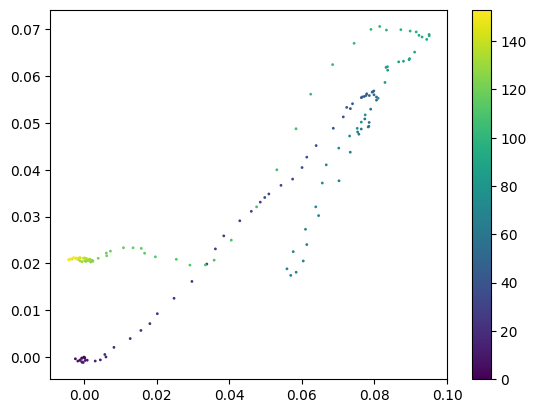

In [ ]:
plt.scatter(ee_in_init_poss[:, 0], ee_in_init_poss[:, 1], s=1, c=range(len(ee_in_init_poss)))
# plt.xlim(0, 0.2)
# plt.ylim(0, 0.2)
plt.colorbar()

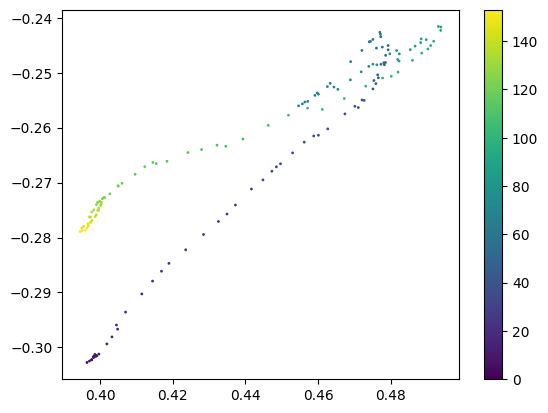

In [ ]:
plt.scatter(gt_ee_pose[:, 0], gt_ee_pose[:, 1], s=1, c=range(len(ee_in_init_poss)))
plt.colorbar()

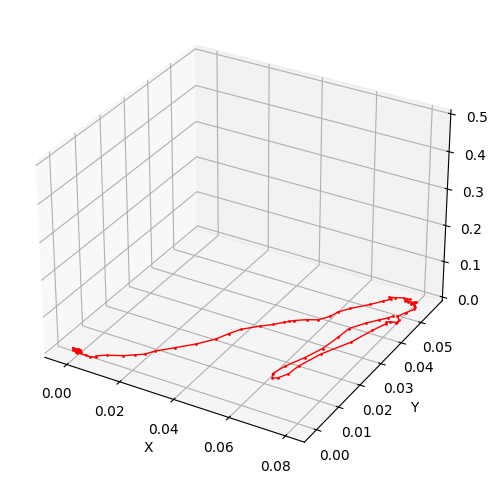

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')



ax.plot(*zip(*ee_in_init_poss[:80]), color='red', marker='o', linestyle='-', linewidth=1, markersize=1)

# Set labels, title, and initial viewpoint
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-1, +1)
# ax.set_ylim(0, 1)
ax.set_zlim(0, 0.5)
ax.view_init(elev=30, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

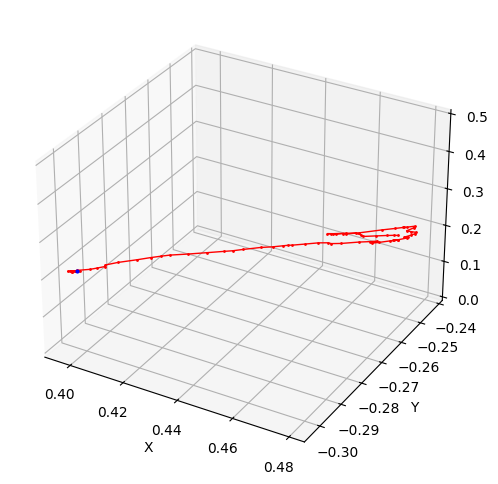

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')



ax.plot(*zip(*gt_ee_pose[:80]), color='red', marker='o', linestyle='-', linewidth=1, markersize=1)
ax.plot(*zip(init_pose), color='blue', marker='o', linestyle='-', linewidth=1, markersize=2)

# Set labels, title, and initial viewpoint
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-1, +1)
# ax.set_ylim(0, 1)
ax.set_zlim(0, 0.5)
ax.view_init(elev=30, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

# Image Projection

In [ ]:
util_path = os.path.abspath("../utils/")
sys.path.append(util_path)
import transformation as trans
import projections as proj


In [ ]:
rgb_p = np.asarray([[429.76348876953125, 0.0, 321.4649658203125, 0.0, 0.0, 429.129150390625, 242.32749938964844, 0.0, 0.0, 0.0, 1.0, 0.0]
]).reshape([3, 4])
rgb_p

array([[429.76348877,   0.        , 321.46496582,   0.        ],
       [  0.        , 429.12915039, 242.32749939,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [ ]:
# simulate a line to front
pts_ee = []
for i in range(10):
    pts_ee.append([0.1 * i, 0, 0])
pts_ee = np.asarray(pts_ee)
pts_ee

array([[0. , 0. , 0. ],
       [0.1, 0. , 0. ],
       [0.2, 0. , 0. ],
       [0.3, 0. , 0. ],
       [0.4, 0. , 0. ],
       [0.5, 0. , 0. ],
       [0.6, 0. , 0. ],
       [0.7, 0. , 0. ],
       [0.8, 0. , 0. ],
       [0.9, 0. , 0. ]])

In [ ]:
pts_ee = ee_in_init_poss.copy()
pts_ee[0]

array([-0., -0.,  0.])

In [ ]:
# camera_T_lidar = np.diag([1, 1, 1, 1])
camera_T_ee = trans.states2SE3([0.12, -0.008, -0.05, 0, 0, 0])
# camera_T_ee = trans.states2SE3([0.12, -0.008, -0.05, 0, 0.2, -0.20])
# camera_T_ee = trans.states2SE3([0.1, 0, 0, 0, 0, 0])

pts_camera = camera_T_ee.dot(trans.xyz2homo(pts_ee).T).T[:,: 3]
# pts_camera

In [ ]:
pts_in_camera_opt = pts_camera.copy()
pts_in_camera_opt = pts_in_camera_opt[:, [1, 2, 0]]
pts_in_camera_opt[:, 2] = pts_in_camera_opt[:, 2]
pts_in_camera_opt[:, 0] = -pts_in_camera_opt[:, 0]
pts_in_camera_opt[:, 1] = -pts_in_camera_opt[:, 1]


In [ ]:
# uv = project_points_to_uv_batch(rgb_p, pts_optical)
uvs = proj.project_point_to_image(pts_in_camera_opt, rgb_p)


img_np:  (480, 640, 3)


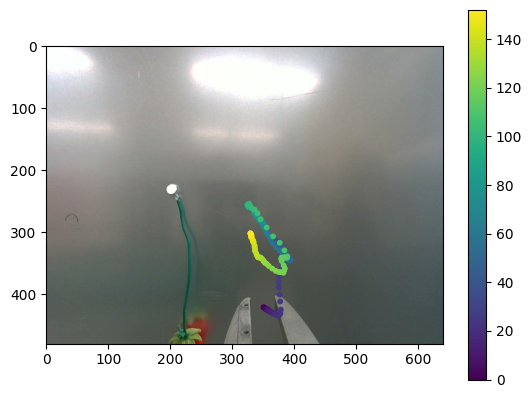

In [ ]:
with h5py.File(h5data_file, "r") as root:
    img_np = root["/observations/images/wrist"][0]
print("img_np: ",img_np.shape)
img_plot = img_np.copy()

plt.imshow(cv.cvtColor(img_np, cv.COLOR_BGR2RGB))
plt.scatter(uvs[:, 0], uvs[:, 1], c=range(len(uvs)), s=10)
plt.colorbar()